# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting toolkit
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

2025-08-14 13:11:52.637556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 13:11:52.640660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 13:11:52.660807: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 13:11:52.686446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755169912.710682  392053 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755169912.71

In [2]:
from scripts.parse_vars import parse_variables

In [3]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])

# Load variables

In [4]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))

In [5]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno = pd.read_pickle(f"{path_pheno}/env_pheno.pkl")
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")

In [6]:
pheno

,x,y,01_pheno_linear,02_pheno_sine_x,03_pheno_sine_y,04_pheno_sine_x_y,05_pheno_discrete
0,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
1,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
2,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
3,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
4,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
...,...,...,...,...,...,...,...
1995,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1996,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1997,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1998,10,10,1.0,0.025641,-1.110223e-16,0.012987,0


In [7]:
pheno_list = list(pheno[[col for col in pheno.columns if col not in ['x', 'y']]].columns)


In [8]:
pheno_list

['01_pheno_linear',
 '02_pheno_sine_x',
 '03_pheno_sine_y',
 '04_pheno_sine_x_y',
 '05_pheno_discrete']

In [9]:
nr_pcs = 5

In [10]:
geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")
min_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/minor_{nr_pcs}_PCs.pkl")
het_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/het_{nr_pcs}_PCs.pkl")
maj_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/major_{nr_pcs}_PCs.pkl")


In [11]:
geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")
min_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")
het_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")
maj_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")

In [12]:
error = 1-(min_reconstruct+ het_reconstruct+ maj_reconstruct)

In [13]:
row_means = (geno_reconstruct - ((maj_reconstruct - min_reconstruct) + error)).mean(axis=0)
#row_means = (geno_reconstruct - (((1-min_reconstruct-het_reconstruct) - min_reconstruct))).mean(axis=0)



In [14]:
row_means

C_1_MAF_0.500       -1.151366
C_2_MAF_0.500       -1.187737
C_3_MAF_0.500       -0.779142
C_4_MAF_0.500       -1.086764
C_5_MAF_0.500       -0.987935
                       ...   
VR_3996_MAF_0.043    2.485517
VR_3997_MAF_0.043    2.656493
VR_3998_MAF_0.042    2.511317
VR_3999_MAF_0.042    2.674236
VR_4000_MAF_0.042    2.605280
Length: 4000, dtype: float32

# PCA

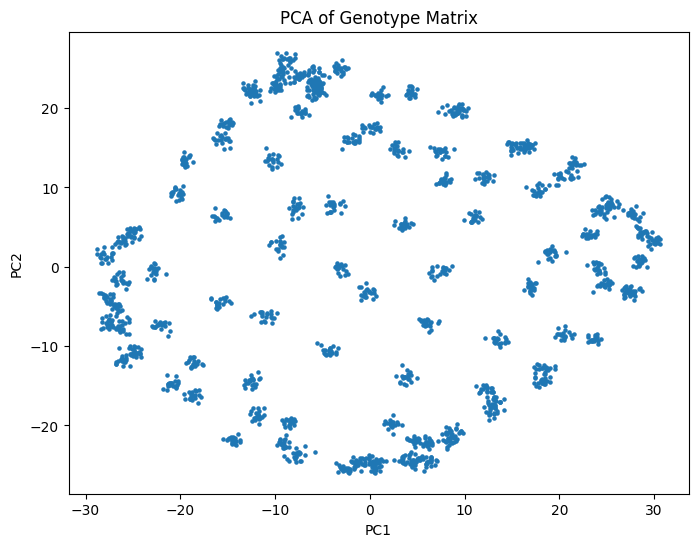

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(geno_pcs['PC1'], geno_pcs['PC2'], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix")
plt.show()


# Gwas

In [16]:
env_factor = "04_pheno_sine_x_y"

In [17]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd

# Extract phenotype
y = pheno[env_factor].values

# Initialize results list
results = []

# Loop through SNPs
for snp in geno.columns:
    x = geno[snp].values
    # Combine SNP with PCs
    X = pd.concat([pd.Series(x, name='SNP'), geno_pcs], axis=1)
    X = add_constant(X)  # Add intercept
    model = OLS(y, X).fit()
    pval = model.pvalues['SNP']  # p-value for SNP term
    logp = -np.log10(pval)
    results.append((snp, logp))

# Create and sort results DataFrame
gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)

# Display
gwas_results


,SNP,-log10(p)
0,C_804_MAF_0.281,89.380100
1,C_800_MAF_0.282,89.361325
2,R_1696_MAF_0.148,68.198955
3,R_1697_MAF_0.147,68.073269
4,R_1658_MAF_0.151,66.672179
...,...,...
3995,R_2747_MAF_0.074,0.001372
3996,R_3109_MAF_0.063,0.000956
3997,R_3015_MAF_0.065,0.000494
3998,R_2524_MAF_0.085,0.000488


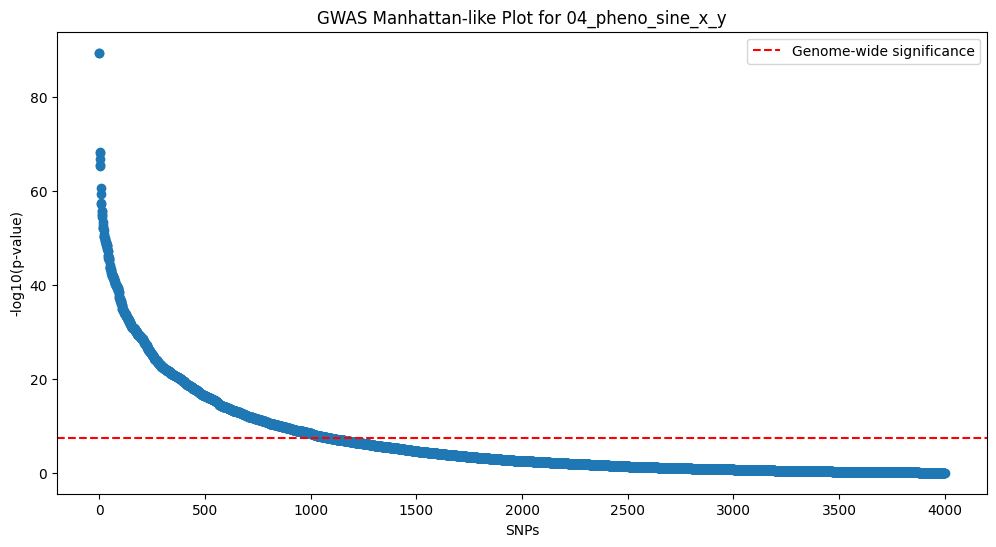

In [18]:


plt.figure(figsize=(12, 6))
plt.plot(gwas_results['-log10(p)'].values, marker='o', linestyle='none')
plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
plt.xlabel('SNPs')
plt.ylabel('-log10(p-value)')
plt.title(f'GWAS Manhattan-like Plot for {env_factor}')
plt.legend()
plt.show()

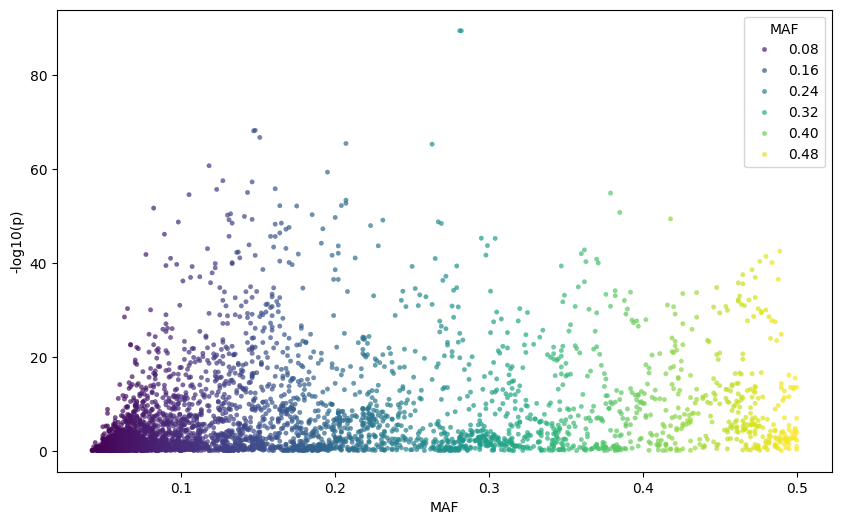

In [19]:


# Extract MAF from SNP names
gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="MAF",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)


In [20]:
gwas_results['maf_deviation'] = gwas_results['SNP'].map(row_means)
gwas_results['maf_deviation_abs'] = gwas_results['maf_deviation'].abs()



In [21]:
gwas_results

,SNP,-log10(p),MAF,maf_deviation,maf_deviation_abs
0,C_804_MAF_0.281,89.380100,0.281,0.516018,0.516018
1,C_800_MAF_0.282,89.361325,0.282,0.497033,0.497033
2,R_1696_MAF_0.148,68.198955,0.148,1.914431,1.914431
3,R_1697_MAF_0.147,68.073269,0.147,1.920070,1.920070
4,R_1658_MAF_0.151,66.672179,0.151,1.813488,1.813488
...,...,...,...,...,...
3995,R_2747_MAF_0.074,0.001372,0.074,2.284530,2.284530
3996,R_3109_MAF_0.063,0.000956,0.063,2.682158,2.682158
3997,R_3015_MAF_0.065,0.000494,0.065,2.474135,2.474135
3998,R_2524_MAF_0.085,0.000488,0.085,2.294656,2.294656


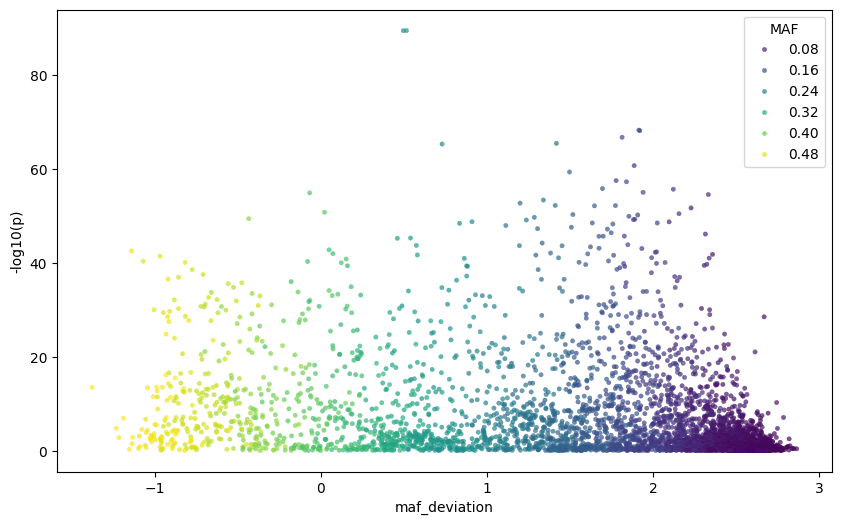

In [22]:

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="maf_deviation",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

# Lets iterate through the PCs 

In [23]:
nrs_pcs = list(set([int(f.split("_")[1]) for f in os.listdir(f"simulation_data//G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs")]))

In [25]:
"""
os.makedirs(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons", exist_ok = True)
for env_factor in pheno_list:
    print(env_factor)
    dfs = []
    for nr_pcs in nrs_pcs:
        geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")
        geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")
        min_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")
        het_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")
        maj_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")
        error = 1-(min_reconstruct+ het_reconstruct+ maj_reconstruct)
        row_means = (geno_reconstruct - ((maj_reconstruct - min_reconstruct) + error)).mean(axis=0)
        
        # Extract phenotype
        y = pheno[env_factor].values
        
        # Initialize results list
        results = []
        
        # Loop through SNPs
        for snp in geno.columns:
            x = geno[snp].values
            # Combine SNP with PCs
            X = pd.concat([pd.Series(x, name='SNP'), geno_pcs], axis=1)
            X = add_constant(X)  # Add intercept
            model = OLS(y, X).fit()
            pval = model.pvalues['SNP']  # p-value for SNP term
            logp = -np.log10(pval)
            results.append((snp, logp))
        
        # Create and sort results DataFrame
        gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
        gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)
        
        # Display
        gwas_results
        gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)
        gwas_results['nr_PCs'] = nr_pcs
        gwas_results['maf_deviation'] = gwas_results['SNP'].map(row_means)
        dfs.append(gwas_results)
    df = pd.concat(dfs, axis=0)
    df.to_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/{env_factor}_{nr_pcs}_PCs.pkl")
"""

'\nos.makedirs(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons", exist_ok = True)\nfor env_factor in pheno_list:\n    print(env_factor)\n    dfs = []\n    for nr_pcs in nrs_pcs:\n        geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")\n        geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")\n        min_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")\n        het_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")\n        maj_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")\n        error = 1-(min_reconstruct+ het_reconstruct+ maj_reconstruct)\n        row_means = (geno_reconstruct - ((maj_reconstruc

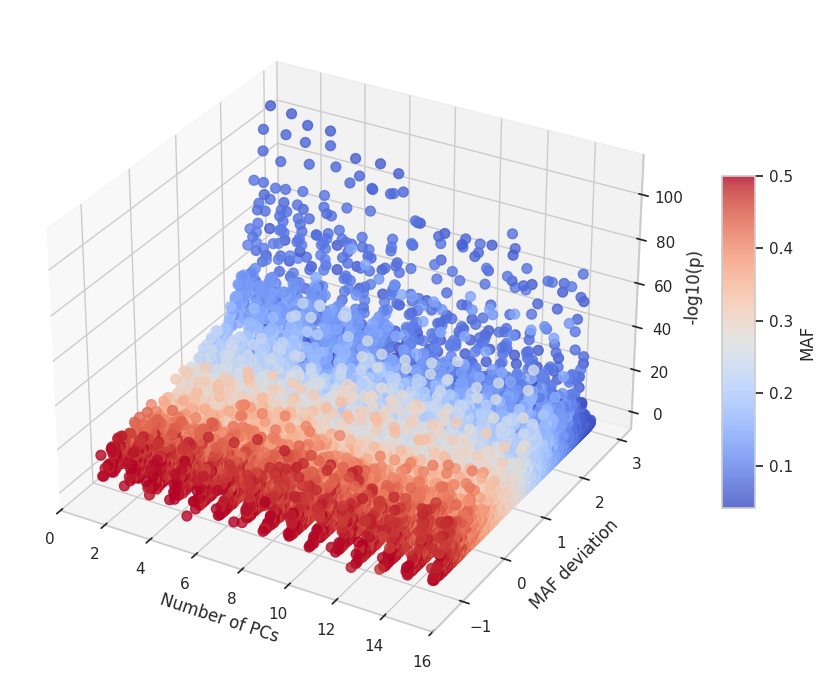

In [26]:
# Optional: make it look like seaborn
sns.set(style="whitegrid")

# Extract variables
x = df['nr_PCs']
y = df['maf_deviation']
z = df['-log10(p)']
hue = df['MAF']

# Create figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter with hue as MAF
sc = ax.scatter(x, y, z,
                c=hue,
                cmap='coolwarm',
                s=50,
                alpha=0.8)

# Labels
ax.set_xlabel('Number of PCs')
ax.set_ylabel('MAF deviation')
ax.set_zlabel('-log10(p)')

# Color bar for MAF
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('MAF')

plt.tight_layout()
plt.show()


In [27]:
comparaison_files = [f for f in os.listdir(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/") if f.startswith("0")]

In [28]:
for file in comparaison_files:
    path_file = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/comparaisons/{file}"

In [29]:
df = pd.read_pickle(path_file)

In [30]:
import pandas as pd
import numpy as np

# Assuming df is your dataframe
bell_curves = []

for pcs, group in df.groupby("nr_PCs"):
    mean_dev = group["maf_deviation"].mean()
    std_dev = group["maf_deviation"].std(ddof=0)  # population std
    
    # Convert to z-scores
    z_scores = (group["maf_deviation"] - mean_dev) / std_dev
    
    bell_curves.append(pd.DataFrame({
        "nr_PCs": pcs,
        "maf_deviation": group["maf_deviation"],
        "z_score": z_scores
    }))

bell_curve_df = pd.concat(bell_curves)


In [31]:
bell_curve_df

,nr_PCs,maf_deviation,z_score
0,1,0.423614,-1.215412
1,1,0.902201,-0.741702
2,1,0.817352,-0.825686
3,1,0.590096,-1.050627
4,1,0.678931,-0.962697
...,...,...,...
3995,15,-0.327875,-1.951107
3996,15,2.591702,0.954498
3997,15,2.396063,0.759794
3998,15,1.351879,-0.279392


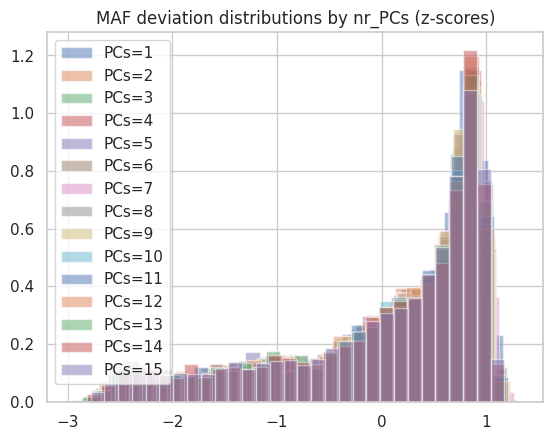

In [32]:
import matplotlib.pyplot as plt

for pcs in bell_curve_df["nr_PCs"].unique():
    subset = bell_curve_df[bell_curve_df["nr_PCs"] == pcs]
    plt.hist(subset["z_score"], bins=30, density=True, alpha=0.5, label=f"PCs={pcs}")

plt.legend()
plt.title("MAF deviation distributions by nr_PCs (z-scores)")
plt.show()


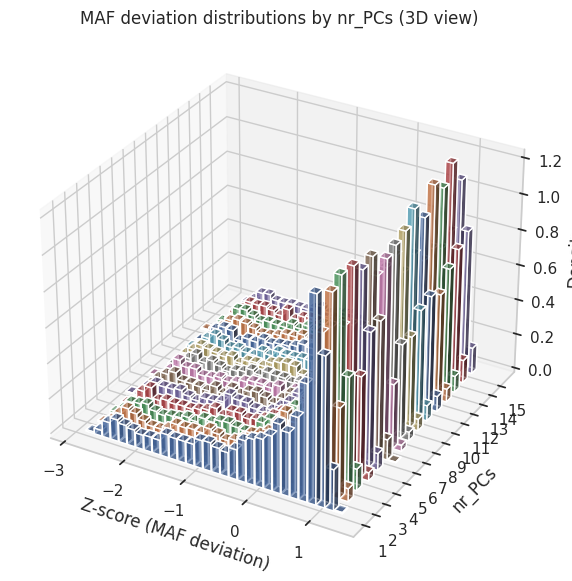

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign numeric positions for nr_PCs so we can place them on the z-axis
pcs_positions = {pcs: i for i, pcs in enumerate(sorted(bell_curve_df["nr_PCs"].unique()))}

for pcs in bell_curve_df["nr_PCs"].unique():
    subset = bell_curve_df[bell_curve_df["nr_PCs"] == pcs]
    
    # Histogram data
    hist_vals, bin_edges = np.histogram(subset["z_score"], bins=30, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Z position for all bars in this group
    z_pos = np.full_like(bin_centers, pcs_positions[pcs], dtype=float)
    
    # Width and depth for bars
    dx = (bin_edges[1] - bin_edges[0]) * 0.9
    dy = 0.5  # thickness for the PC axis
    
    # Plot bars
    ax.bar3d(bin_centers, z_pos, np.zeros_like(hist_vals),
             dx, dy, hist_vals, alpha=0.6)

# Labels
ax.set_xlabel("Z-score (MAF deviation)")
ax.set_ylabel("nr_PCs")
ax.set_zlabel("Density")
ax.set_yticks(list(pcs_positions.values()))
ax.set_yticklabels(list(pcs_positions.keys()))
ax.set_title("MAF deviation distributions by nr_PCs (3D view)")

plt.show()
